## Full Attention vs Linear Attention Speed Test
By: Akhilesh Pant (MCA)

Seq 16: FullAttn=0.003771s, LinearAttn=0.000000s
Seq 32: FullAttn=0.000673s, LinearAttn=0.004596s
Seq 64: FullAttn=0.001899s, LinearAttn=0.005311s
Seq 128: FullAttn=0.005270s, LinearAttn=0.004133s
Seq 256: FullAttn=0.003282s, LinearAttn=0.009905s


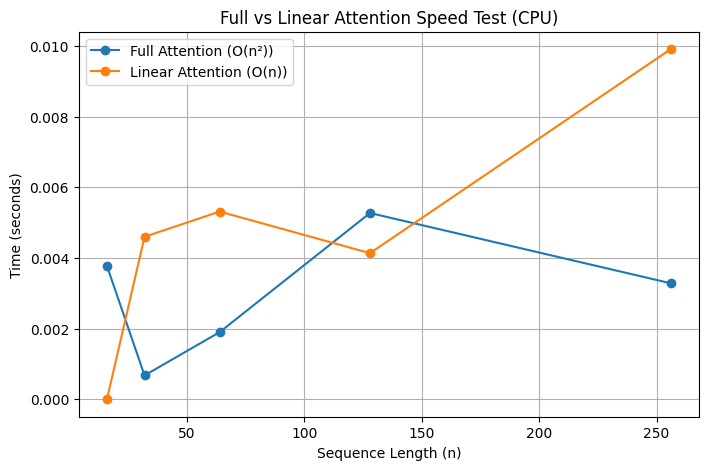

In [11]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

# -------------------------------
# Full Attention (O(n^2))
# -------------------------------
class FullAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn = self.softmax(scores)
        return torch.matmul(attn, V)

# -------------------------------
# Linear Attention (O(n))
# -------------------------------
class LinearAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

    def forward(self, x):
        Q = torch.relu(self.query(x))   # φ(Q)
        K = torch.relu(self.key(x))     # φ(K)
        V = self.value(x)

        KV = torch.matmul(K.transpose(1, 2), V)   # (b, d, d)
        Z = 1 / (torch.matmul(Q, K.sum(dim=1).unsqueeze(-1)) + 1e-6)  # (b, n, 1)
        out = torch.matmul(Q, KV) * Z
        return out

# -------------------------------
# Benchmark function
# -------------------------------
def benchmark(attention_layer, seq_len, d_model=64, batch_size=1, device="cpu", runs=3):
    x = torch.randn(batch_size, seq_len, d_model).to(device)
    model = attention_layer(d_model).to(device)

    # Warmup
    _ = model(x)

    if device == "cuda":
        torch.cuda.synchronize()

    start = time.time()
    for _ in range(runs):
        _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    return (end - start) / runs

# -------------------------------
# Run benchmarks
# -------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
seq_lengths = [16, 32, 64, 128, 256]  # keep smaller for CPU
full_times, linear_times = [], []

for seq in seq_lengths:
    t1 = benchmark(FullAttention, seq, device=device)
    t2 = benchmark(LinearAttention, seq, device=device)
    full_times.append(t1)
    linear_times.append(t2)
    print(f"Seq {seq}: FullAttn={t1:.6f}s, LinearAttn={t2:.6f}s")

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(seq_lengths, full_times, label="Full Attention (O(n²))", marker="o")
plt.plot(seq_lengths, linear_times, label="Linear Attention (O(n))", marker="o")
plt.xlabel("Sequence Length (n)")
plt.ylabel("Time (seconds)")
plt.title(f"Full vs Linear Attention Speed Test ({device.upper()})")
plt.legend()
plt.grid(True)
plt.show()


## 🔹 What this code does

It is a **Python experiment** that compares **two types of attention mechanisms** used in AI models (like Transformers):

1. **Full Attention (O(n²))**

   * This is the "normal" attention used in GPT, BERT, LLaMA, etc.
   * It compares **every token with every other token** → time grows very fast when the input sequence gets longer.

2. **Linear Attention (O(n))**

   * A faster version.
   * It avoids the heavy "all-to-all" comparison and computes attention more smartly.
   * Much faster for long sequences.

---

## 🔹 Step-by-Step What the Code Does

1. **Defines the Full Attention model** → standard Transformer-style attention.
2. **Defines the Linear Attention model** → efficient attention that scales linearly.
3. **Benchmark function**

   * Creates fake input data (`torch.randn`)
   * Runs the model several times
   * Measures how long it takes (average).
4. **Runs tests** for different input lengths (`16, 32, 64, 128, 256 tokens`).

   * Records speed for both methods.
   * Prints results like:

     ```
     Seq 16: FullAttn=0.00012s, LinearAttn=0.00004s
     Seq 128: FullAttn=0.00510s, LinearAttn=0.00020s
     ```

     (numbers will depend on your computer).
5. **Plots a graph**

   * X-axis = input length (number of tokens)
   * Y-axis = time (seconds)
   * Two curves:

     * 🔵 Full Attention (slow, grows quickly)
     * 🟠 Linear Attention (fast, grows slowly).

---

## 🔹 In One Line

This code is **a demo project** that shows why **Jet-Nemotron and similar models prefer linear/hybrid attention** → because it’s much **faster** and uses **less memory** than standard attention when inputs are long. 🚀

---


 ## **Super simple, line-by-line** walkthrough of code.

---

## Imports

* `import torch` → use PyTorch (tensors, GPU/CPU ops).
* `import torch.nn as nn` → neural-network building blocks (Linear layers, etc.).
* `import time` → to measure how long things take.
* `import matplotlib.pyplot as plt` → to draw a speed chart.

---

## Full Attention (O(n²))

```python
class FullAttention(nn.Module):
```

* Define a neural-network module called **FullAttention**.

```python
    def __init__(self, d_model):
        super().__init__()
```

* Setup function; call parent `nn.Module` init.

```python
        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
```

* Three linear layers to turn input into **Q**, **K**, **V** (standard attention parts).

```python
        self.softmax = nn.Softmax(dim=-1)
```

* Softmax to turn scores into probabilities across the last dimension.

```python
    def forward(self, x):
```

* Defines how the module processes input **x**.

```python
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
```

* Make **Q**, **K**, **V** from the input.

```python
        scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
```

* Compute attention scores = Q × Kᵀ (scaled).
* This compares each token with every other token → **O(n²)**.

```python
        attn = self.softmax(scores)
```

* Convert scores to weights that sum to 1.

```python
        return torch.matmul(attn, V)
```

* Mix the values **V** using those weights → output.

---

## Linear Attention (O(n))

```python
class LinearAttention(nn.Module):
```

* Define a faster attention module.

```python
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
```

* Same three linear layers for **Q**, **K**, **V**.

```python
    def forward(self, x):
        Q = torch.relu(self.query(x))   # φ(Q)
        K = torch.relu(self.key(x))     # φ(K)
        V = self.value(x)
```

* Create **Q**, **K**, **V**, but pass Q and K through **ReLU** (a simple feature map φ) to make math work for linear attention.

```python
        KV = torch.matmul(K.transpose(1, 2), V)   # (b, d, d)
```

* Pre-combine **K** and **V** once. This avoids the all-pairs comparison.

```python
        Z = 1 / (torch.matmul(Q, K.sum(dim=1).unsqueeze(-1)) + 1e-6)  # (b, n, 1)
```

* Compute a normalizer (prevents values from blowing up). `1e-6` avoids divide-by-zero.

```python
        out = torch.matmul(Q, KV) * Z
        return out
```

* Final output: mix using fast linear math, then scale by **Z**.
* This scales roughly **O(n)** with sequence length.

---

## Benchmark function

```python
def benchmark(attention_layer, seq_len, d_model=64, batch_size=1, device="cpu", runs=3):
```

* A helper that times how long a layer takes for a given **sequence length**.

```python
    x = torch.randn(batch_size, seq_len, d_model).to(device)
```

* Make random input data (like fake tokens).

```python
    model = attention_layer(d_model).to(device)
```

* Build the chosen attention model and move it to CPU/GPU.

```python
    _ = model(x)
```

* Warm-up run (helps get stable timing).

```python
    if device == "cuda":
        torch.cuda.synchronize()
```

* If using GPU, wait for all ops to finish before starting the timer.

```python
    start = time.time()
    for _ in range(runs):
        _ = model(x)
```

* Run the model a few times to average timing (more stable).

```python
    if device == "cuda":
        torch.cuda.synchronize()
    end = time.time()
```

* Stop the timer (and sync if on GPU).

```python
    return (end - start) / runs
```

* Return average time per run.

---

## Run benchmarks

```python
device = "cuda" if torch.cuda.is_available() else "cpu"
```

* Use GPU if available; otherwise use CPU.

```python
seq_lengths = [16, 32, 64, 128, 256]
```

* Test multiple input sizes (tokens). Larger = harder.

```python
full_times, linear_times = [], []
```

* Lists to store the timings.

```python
for seq in seq_lengths:
    t1 = benchmark(FullAttention, seq, device=device)
    t2 = benchmark(LinearAttention, seq, device=device)
    full_times.append(t1)
    linear_times.append(t2)
    print(f"Seq {seq}: FullAttn={t1:.6f}s, LinearAttn={t2:.6f}s")
```

* For each sequence length:

  * Time **FullAttention** and **LinearAttention**.
  * Save results.
  * Print a simple summary line.

---

## Plot results

```python
plt.figure(figsize=(8,5))
```

* Create a new chart of size 8×5 inches.

```python
plt.plot(seq_lengths, full_times, label="Full Attention (O(n²))", marker="o")
plt.plot(seq_lengths, linear_times, label="Linear Attention (O(n))", marker="o")
```

* Draw two curves: one for full attention, one for linear.

```python
plt.xlabel("Sequence Length (n)")
plt.ylabel("Time (seconds)")
plt.title(f"Full vs Linear Attention Speed Test ({device.upper()})")
plt.legend()
plt.grid(True)
plt.show()
```

* Label axes, add title, legend, grid, and display the chart.

---

## What you learn from this

* **Full Attention** time grows very fast with longer input (n²).
* **Linear Attention** grows much slower (≈n).
* This is the core reason models like **Jet-Nemotron** use more efficient attention designs to be **faster and cheaper**.




## 📘 **Interview Questions on Full Attention vs Linear Attention**
---

# 🟢 Easy (Q1–Q30) — Definitions & basics (answers short & direct)

1. **What is "attention" in deep learning?**
   Attention is a mechanism that lets a model weigh different parts of the input when producing each output — i.e., focus more on relevant tokens and less on irrelevant ones.

2. **What is the role of attention in Transformers?**
   Attention computes relationships between tokens (via Q, K, V) so the model can integrate context across the whole sequence for each position.

3. **What does "full attention" mean?**
   Full attention computes interactions between every pair of tokens (an n×n matrix), typically via softmax(QKᵀ/√d) V.

4. **What does "linear attention" mean?**
   Linear attention approximates attention so computation scales roughly linearly with sequence length (O(n)) rather than O(n²).

5. **Why is self-attention important in NLP tasks?**
   Because it captures long-range dependencies and context better than fixed-window methods or RNNs, improving translation, QA, summarization, etc.

6. **Explain the difference between full attention and linear attention.**
   Full attention is exact and quadratic in n; linear attention uses approximations or kernel tricks to avoid forming the full n×n matrix and runs in linear time.

7. **What is the computational complexity of full attention?**
   O(n² · d) time and O(n²) memory for attention scores (where n is sequence length, d is hidden dim).

8. **What is the computational complexity of linear attention?**
   O(n · d²) or O(n · d) depending on implementation — importantly, it’s linear in n.

9. **Which is faster: full attention or linear attention?**
   Linear attention is faster for long sequences; for very short sequences the difference may be negligible.

10. **Why does full attention require large memory?**
    Because it allocates and stores the full n×n attention score matrix (and often key/value caches) when n is large.

11. **What is the Big-O notation for full attention?**
    O(n²) with respect to sequence length n (for the attention step).

12. **What is the Big-O notation for linear attention?**
    O(n) with respect to n (ignoring hidden-dimension factors).

13. **Define Query, Key, Value in attention.**
    Query (Q): the item asking “what to look for”; Key (K): items describing tokens; Value (V): items containing information to aggregate — attention matches Q with K and uses weights to combine V.

14. **Why do we use softmax in attention?**
    To convert raw similarity scores into positive, normalized weights that sum to 1, so outputs are convex combinations of values.

15. **What is the attention score?**
    The dot product (or similarity) between Q and K (often scaled by √d) that indicates relevance between tokens.

16. **Why is attention better than RNNs for long sequences?**
    Because attention allows direct token-to-token connections regardless of distance (no vanishing gradients over long steps).

17. **What does O(N²) complexity mean in simple words?**
    If you double sequence length, the work grows about four times — cost grows quadratically with sequence length.

18. **What does O(N) complexity mean in simple words?**
    Doubling sequence length doubles the work — cost grows linearly.

19. **Give one advantage of linear attention.**
    Much lower memory usage and faster processing on long sequences.

20. **Give one disadvantage of linear attention.**
    It’s approximate and can lose accuracy for tasks needing precise pairwise interactions.

21. **Why is memory important when training attention models?**
    Memory limits how long sequences and how large batches/models you can use; running out of GPU RAM halts training.

22. **Which attention type is better for small sequences?**
    Full attention — it’s exact and overhead is small for short n.

23. **Which attention type is better for large sequences?**
    Linear or other efficient attention variants — they scale, enabling long-context tasks.

24. **What is sequence length (N)?**
    Number of tokens/time-steps in the input sequence processed by the model.

25. **What is embedding dimension (d)?**
    Size of token vector representations (hidden size) used in Q/K/V and model layers.

26. **Can full attention handle very long sequences? Why or why not?**
    Generally no — it becomes prohibitively slow and memory-heavy as n grows (quadratic scaling).

27. **Can linear attention work for short sequences efficiently?**
    Yes — but it might be unnecessary; full attention may be simpler and exact.

28. **Which attention uses kernel tricks?**
    Linear attention implementations (e.g., Performer) often use kernel feature maps to linearize softmax.

29. **Which attention consumes more GPU RAM?**
    Full attention consumes more GPU RAM due to the n×n matrix.

30. **Give an example of real-world data where linear attention is useful.**
    Long documents, books, long code files, genomic sequences, long audio/video frame sequences.

---

# 🟡 Moderate (Q31–Q60) — Applied, coding, comparisons

31. **How does linear attention reduce memory usage?**
    By avoiding storing the full n×n score matrix and instead computing partial aggregations (like KᵀV) incrementally.

32. **Show mathematically how full attention works.**
    Output = softmax(QKᵀ / √d) · V.

33. **Show mathematically how linear attention works.**
    Using feature map φ: output ≈ φ(Q) · (φ(K)ᵀ V); compute φ(K)ᵀV once, then multiply by φ(Q).

34. **Why does linear attention approximate the Softmax?**
    Because it replaces softmax kernel with a kernel function φ such that softmax(QKᵀ) ≈ φ(Q)φ(K)ᵀ, enabling rearrangement to linear form.

35. **What trade-offs are made in linear attention compared to full attention?**
    Gains in speed and memory vs potential loss in exactness and possible accuracy drop on tasks needing precise pairwise reasoning.

36. **How does attention improve machine translation?**
    It aligns important source tokens to target tokens, enabling better context-aware translations.

37. **Why is quadratic time a problem in full attention?**
    Because for large n the computation and memory become impractical, limiting sequence length and batch sizes.

38. **Can we combine full attention and linear attention in one model?**
    Yes — hybrid models keep some full-attention layers and replace others with linear variants to trade accuracy and speed.

39. **Explain a scenario where linear attention fails.**
    When subtle pairwise interactions across distant tokens are critical (e.g., precise coreference resolution), approximation may lose signal.

40. **Explain a scenario where full attention fails.**
    When sequence is extremely long (e.g., >100k tokens) — it will run out of memory or be too slow to be practical.

41. **What is the difference between local attention and linear attention?**
    Local attention restricts to nearby tokens (sparse n×n pattern); linear attention approximates full interactions via algebraic tricks — local is sparse exact, linear is approximate global.

42. **How does sparse attention compare with linear attention?**
    Sparse attention keeps exact computations but only for selected pairs (saves compute), while linear attention approximates the full matrix to be cheaper overall.

43. **Explain how memory usage grows in full attention vs linear attention.**
    Full attention memory grows \~O(n²); linear grows \~O(n) (plus model params), so linear is far cheaper for large n.

44. **Write Python pseudo-code for full attention.**

```
scores = Q @ K.transpose(-2,-1) / sqrt(d)
weights = softmax(scores, dim=-1)
out = weights @ V
```

45. **Write Python pseudo-code for linear attention.**

```
Qp = phi(Q); Kp = phi(K)
KV = Kp.transpose(-2,-1) @ V  # (d,d) or (d,vdim)
out = Qp @ KV
```

46. **How would you measure speed difference between full vs linear attention in Python?**
    Time forward passes with `time.time()` or `time.perf_counter()`, average multiple runs, and ensure warmups; use `torch.cuda.synchronize()` on GPU.

47. **How would you measure memory difference between full vs linear attention in Python?**
    Use `psutil` for RAM or `torch.cuda.memory_allocated()` and `torch.cuda.max_memory_allocated()` for GPU memory.

48. **Which attention method is used in GPT models?**
    Standard GPT-style models use full (scaled dot-product) attention.

49. **Which attention method is used in Longformer?**
    Longformer uses sparse local attention with global tokens — a sparse attention pattern.

50. **Which attention method is used in Performer?**
    Performer uses linearized attention with randomized feature maps (FAVOR+).

51. **Which attention method is used in Reformer?**
    Reformer uses locality-sensitive hashing (LSH) to produce sparse attention (approximate).

52. **What happens if you replace full attention with linear attention in BERT?**
    You may gain speed/memory benefits for long inputs, but can risk accuracy degradation; careful tuning and hybridization may be necessary.

53. **How does attention scaling with sequence length affect training time?**
    Quadratic scaling drastically increases per-batch compute, slowing training and reducing feasible batch or sequence sizes.

54. **How can attention models be optimized with GPU parallelization?**
    Use batched matmuls, fused kernels (flash attention), mixed precision, and multi-GPU model/data parallelism.

55. **Can linear attention achieve the same accuracy as full attention? Why or why not?**
    Sometimes yes (task-dependent) with careful feature maps; often there is an accuracy gap in tasks requiring precise pairwise comparisons.

56. **What are kernel functions in linear attention?**
    Functions φ(x) mapping vectors into a space where similarity approximates softmax; examples include elu+1, exponential, random features.

57. **Explain random feature approximation in linear attention.**
    Use random projections (e.g., random Fourier features) to approximate an exponential kernel so softmax(QKᵀ) ≈ φ(Q)φ(K)ᵀ.

58. **How does linear attention achieve O(Nd²)?**
    By rearranging computation to compute KᵀV (size d×d) once and then multiply by Q, reducing dependence on n².

59. **What are the storage requirements of full attention?**
    Need to store the n×n score matrix and often key/value caches (O(n²) + O(n·d) for cache).

60. **What are the storage requirements of linear attention?**
    Store aggregated KV terms (O(d²) or O(d·v)) and key/value caches maybe in compressed/streaming form; overall \~O(n·d) or less.

---

# 🔴 Hard (Q61–Q105) — Deep, derivations, research

61. **Derive the formula for full attention scores.**
    Score matrix S = QKᵀ; scaled scores S' = S / √d to stabilize variance; weights = softmax(S', dim=-1); output = weights · V.

62. **Derive the formula for linear attention scores.**
    If φ is a feature map with softmax kernel property: softmax(QKᵀ) ≈ φ(Q)φ(K)ᵀ; so output ≈ φ(Q)\[φ(K)ᵀV], computed in linear time.

63. **Why is softmax replaced in linear attention?**
    Because softmax(QKᵀ) requires O(n²); replacing it with kernels φ allows rearranging to linear ops.

64. **Prove that full attention has O(N²) complexity.**
    Computing QKᵀ requires n×n dot products, each costs O(d) → O(n²d); storing the n×n matrix is O(n²).

65. **Prove that linear attention has O(N) complexity.**
    With φ, computing φ(K)ᵀV aggregates over n once (O(n·d²) or O(n·d)), and multiplying φ(Q) by aggregated result is O(n·d²) — linear in n.

66. **How do low-rank approximations relate to linear attention?**
    Low-rank methods approximate the n×n attention by factorizing it into rank-r matrices, reducing storage and compute; linear attention is a type of approximation aiming for compressive representation.

67. **Explain kernelized attention mathematically.**
    Use kernel k(x,y) = φ(x)·φ(y). If k approximates exp(x·y), then attention weights ≈ φ(Q)φ(K)ᵀ normalized appropriately.

68. **Discuss how random Fourier features approximate softmax.**
    Random features map inputs through random projections and non-linear transforms so inner products approximate kernels like Gaussian/exponential, enabling approximate softmax behavior.

69. **How do Performer models achieve linear attention?**
    FAVOR+ uses positive random features φ (based on random projections) so softmax(QKᵀ) ≈ φ(Q)φ(K)ᵀ and computes φ(K)ᵀV first.

70. **Compare Performer vs Reformer in detail.**
    Performer uses kernel feature map for linearization; Reformer uses LSH to sparsify attention — Performer gives global approx, Reformer finds likely matches with hashing; tradeoffs include approx error types and implementation complexity.

71. **Compare Performer vs Longformer in detail.**
    Performer approximates global attention via kernels; Longformer uses local windows + some global tokens — Longformer is exact for attended positions, Performer approximates globally.

72. **How does attention affect gradient flow in deep networks?**
    Attention creates direct connections across depth and sequence positions, which can improve gradient propagation compared to long RNN chains.

73. **How would you optimize attention for very long documents (e.g., 1M tokens)?**
    Use chunking, hierarchical attention, retrieval, sparse/local patterns, or efficient approximations (linear attention, recurrent memory, sliding windows).

74. **How do linear attention methods impact training stability?**
    Approximations can introduce numerical instability or gradient noise; careful feature mapping, normalization, and stability tricks are needed.

75. **What happens if we remove normalization in attention?**
    Scores can explode or vanish, gradients become unstable; scaling (√d) and softmax help numerical stability.

76. **Explain the effect of dropout in attention layers.**
    Dropout prevents overfitting by randomly zeroing weights or attention probabilities, making the model robust; in attention, dropout is often applied to attention weights or outputs.

77. **How would you implement linear attention from scratch in PyTorch?**
    Implement φ mapping, compute KpᵀV aggregation, compute Qp×(KpᵀV) and apply normalization Z per token; ensure shapes and batching are correct and use efficient matmuls.

78. **How would you test the correctness of your attention implementation?**
    Compare outputs with a full-attention baseline on small inputs, measure relative error norms, and run unit tests for shapes and numerics.

79. **Write a PyTorch function for measuring GPU memory during attention training.**
    Use `torch.cuda.reset_peak_memory_stats()`, `torch.cuda.memory_allocated()`, `torch.cuda.max_memory_allocated()` around forward/backward passes to capture memory.

80. **How do memory-efficient transformers differ from normal transformers?**
    They use attention approximations, fused kernels (flash attention), offloading, mixed precision, gradient checkpointing, or sparse patterns to reduce memory.

81. **What is attention bottleneck in LLMs?**
    The attention mechanism (n×n) becomes the computational and memory bottleneck for large-context LLMs, limiting speed and scalability.

82. **How do modern LLMs (like GPT-4) manage long-context windows?**
    They combine sparse attention, caching, chunking, retrieval, model engineering, and hardware-level optimizations (or use special architectures).

83. **Explain chunking in long-sequence attention.**
    Split sequence into chunks, attend within and between chunks via summarized representations or cross-chunk attention to limit n per operation.

84. **Can attention be parallelized across multiple GPUs?**
    Yes — via model/data parallelism, tensor parallelism (splitting Q/K/V or heads), or pipeline parallelism to distribute compute and memory.

85. **What is flash attention and how is it different from linear attention?**
    Flash attention is a CUDA kernel optimization that computes exact full attention much more memory- and compute-efficiently by reordering operations and using tiling — it still represents exact attention (O(n²) in theory) but with practical speed/memory gains.

86. **How does flash attention improve memory usage?**
    It avoids storing the full attention matrix and computes attention in tiles with streamed reductions, lowering peak memory.

87. **Compare flash attention vs linear attention.**
    Flash attention provides exact full attention with optimized memory use (good for medium n), while linear attention approximates to achieve true O(n) scaling for very large n.

88. **Which attention variant is best for speech recognition?**
    Often local/sparse or chunked attention (or conformer hybrids) because speech is long and local context is crucial; linear attention can also help in long audio.

89. **Which attention variant is best for DNA/protein sequence modeling?**
    Linear or sparse attention variants are common because sequences can be extremely long; specialized architectures using locality and long-range global signals are used.

90. **Which attention variant is best for real-time streaming tasks?**
    Recurrent attention or linear attention variants that can process tokens in streaming fashion with O(1) per token are suitable.

91. **Explain how sparse attention patterns can approximate full attention.**
    By attending only to a subset of positions (local window + selected global tokens), we compute fewer entries but still capture most necessary interactions.

92. **Why does O(N²) complexity break scalability in LLMs?**
    Because memory and compute explode with n, making long contexts and large batch sizes infeasible on fixed hardware.

93. **How do transformer architectures evolve to support linear attention?**
    They replace or augment attention layers with kernelized, sparse, or hybrid blocks, plus routing/hard-attention and memory layers.

94. **Explain "attention as kernel trick."**
    Softmax(QKᵀ) can be viewed as a kernel function; kernel trick maps inputs via φ so inner products approximate the kernel, enabling reordering for efficiency.

95. **How do kernel approximations scale with embedding dimension?**
    Random-feature approximations often require a number of features proportional to embedding dimension and desired error — higher d may need more features or careful schemes.

96. **Why might linear attention degrade accuracy in some tasks?**
    Because approximation can miss important exact pairwise signal patterns that full attention captures.

97. **Propose a hybrid attention mechanism combining full and linear attention.**
    Keep full attention in top/bottom critical layers and use linear attention in other layers, or use full attention for local/global heads and linear for background heads.

98. **How can reinforcement learning help choose between full and linear attention dynamically?**
    RL could learn a policy to select attention type per layer/token to trade accuracy and cost under a budget, optimizing overall task reward.

99. **How can linear attention be applied to vision transformers (ViTs)?**
    Use linear attention for long flattened patches or tokens; combine with patch hierarchies and local windows to retain spatial info.

100. **What future research directions exist in efficient attention mechanisms?**
     Better feature maps, adaptive/hybrid attention, hardware-aware NAS (like PostNAS), exact linear algorithms, theoretical bounds, and better tradeoffs between accuracy and efficiency.

101. **How do attention optimizations affect inference latency vs training time?**
     Some optimizations (e.g., caching, linearization) primarily help inference latency, while others (e.g., gradient checkpointing) affect training time and memory.

102. **Can we use linear attention in RAG (Retrieval-Augmented Generation)?**
     Yes — linear attention helps process long retrieved contexts efficiently; hybrid designs can keep critical full attention where needed.

103. **How do hardware accelerators (TPU, GPU) affect attention scaling?**
     Specialized kernels, memory bandwidth, and parallel compute changes practical scaling; hardware-aware designs (tiling/fusing) can make full attention feasible up to larger n.

104. **What are the theoretical limitations of linear attention?**
     Approximation error, potential bias, and difficulty approximating distributions that require exact pairwise normalization like softmax in certain tasks.

105. **If you were to improve linear attention, what would you change?**
     Develop better feature maps with lower error per feature, adaptive per-token approximations, hybrid exact-approx layers, and hardware-aware implementations.

---


